# Autoencoders

In [1]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp
import json
from sklearn.model_selection import train_test_split
from tools.audio_tools import read_audio, write_audio, play_audio
from tools.feature_tools import compute_mels, compute_imels, compute_mfcc, compute_imfcc, load_data, normalize_features, denormalize_features
from tools.constants import cut_classical_path, cut_jazz_path, models_path
from tools.plot_tools import make_figax, plot_history, plot_audio, plot_spectral_feature
from tools.tensorflow_tools import Conv2DEncoder, Conv2DDecoder, MLP

2023-11-17 14:13:38.194811: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 14:13:38.434037: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 14:13:38.434085: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 14:13:38.435311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 14:13:38.538936: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 14:13:38.540383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Data Loading

### Load Audio & Extract Features

In [3]:
# Load samples from both styles
X_classical_raw = load_data(cut_classical_path)
X_jazz_raw = load_data(cut_jazz_path)

# Concatenate (train on all samples)
X_raw = np.concatenate((X_classical_raw, X_jazz_raw))

# Print feature shape
print(f"{X_raw.shape = }")

100 %
100 %
X_raw.shape = (1019, 67, 128, 1)


### Train - Validation - Test Split

In [4]:
# Fraction of data to keep apart for validation
test_fraction = 0.1
# Perform split
X_raw_train, X_raw_test = train_test_split(X_raw, test_size=test_fraction)
# Verify split shapes
print(f"{X_raw_train.shape = }")
print(f"{X_raw_test.shape = }")

X_raw_train.shape = (917, 67, 128, 1)
X_raw_test.shape = (102, 67, 128, 1)


In [5]:
input_shape = X_raw_train.shape[1:]
print(f"{input_shape = }")

input_shape = (67, 128, 1)


### Normalize Features

In [6]:
# Perform normalization
X_train, X_test = normalize_features(X_raw_train, X_raw_test)

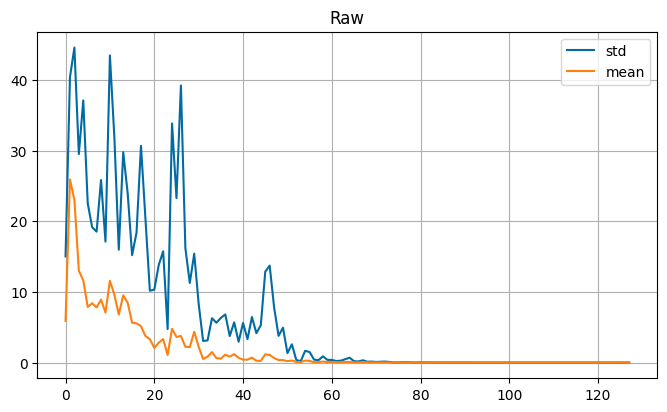

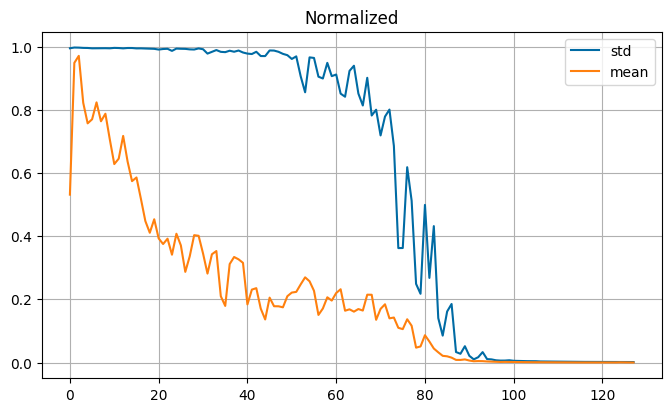

In [7]:
# See the effect of normalization
fig, ax = make_figax()
ax.plot(np.std(X_raw_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_raw_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_raw_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Raw")
plt.show()


fig, ax = make_figax()
ax.plot(np.std(X_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Normalized")
plt.show()

## Autoencoders

### Test Script

In [8]:
nop = lambda x: x

def test_autoencoder(autoencoder, test_set = X_test, plot_transforms = True, plot_raw_transforms = True, plot_waveforms = True):
  # Pick sample at random
  print("Picking Sample")
  choice = np.random.choice(len(test_set))
  x = test_set[choice]

  # Autencoder
  print("Autencoding")
  x_hat = np.array(autoencoder(x.reshape((1, *x.shape))))

  if plot_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x, fn=nop)
    ax.set_title("Original Preprocessed Spectrum")
    fig, ax = plot_spectral_feature(x_hat, fn=nop)
    ax.set_title("Reconstructed Preprocessed Spectrum")
    plt.show()

  # Postprocess
  print("Postprocessing")
  x_raw = denormalize_features(x.reshape((1, *x.shape)))[0]
  x_raw_hat = denormalize_features(x_hat.reshape((1, *x.shape)))[0]

  if plot_raw_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x_raw)
    ax.set_title("Original Raw Spectrum")
    fig, ax = plot_spectral_feature(x_raw_hat)
    ax.set_title("Reconstructed Raw Spectrum")
    plt.show()

  # Reconstruct Audio
  print("Reconstructing Audio")
  s = np.squeeze(compute_imels(x_raw))
  s_hat = np.squeeze(compute_imels(x_raw_hat))

  if plot_waveforms:
    fig, ax = plot_audio(s)
    ax.set_title("Original Waveform")
    fig, ax = plot_audio(s_hat)
    ax.set_title("Reconstructed Waveform")
    plt.show()

  # Play audio
  print("Original Audio")
  player = play_audio(s)
  print("Reconstructed Audio")
  player = play_audio(s_hat)
  print()

In [9]:
def free_memory(autoencoder):
  krs.backend.clear_session()
  del autoencoder.encoder
  del autoencoder.decoder
  del autoencoder
  krs.backend.clear_session()

In [10]:
os.makedirs(models_path, exist_ok = True)
def save_autoencoder(autoencoder, params, history, name):
    # Define and make directory
    autoencoder_path = os.path.join(models_path, name)
    os.makedirs(autoencoder_path, exist_ok = True)
    
    # Save parameters
    with open(os.path.join(autoencoder_path, "params.json"), "w") as params_file:
        json.dump(params, params_file)
        
    # Save history
    with open(os.path.join(autoencoder_path, "history.json"), "w") as history_file:
        if not isinstance(history, dict):
            history = history.history
        json.dump(history, history_file)
    
    # Save model
    autoencoder.save(os.path.join(autoencoder_path, "model.keras"))

def load_autoencoder(name, load_model = True):
    # Define path
    autoencoder_path = os.path.join(models_path, name)
    
    # Load parameters
    with open(os.path.join(autoencoder_path, "params.json"), "r") as params_file:
        params = json.load(params_file)
    
    # Load history
    with open(os.path.join(autoencoder_path, "history.json"), "r") as history_file:
        history = json.load(history_file)
    
    # Load model
    autoencoder = None
    if load_model:
        autoencoder = krs.models.load_model(os.path.join(autoencoder_path, "model.keras"))
    
    return autoencoder, params, history

### Convolutional Autoencoder

In [11]:
@krs.saving.register_keras_serializable()
class Conv2DAutoencoder(krs.models.Model):
    def __init__(
        self,
        feature_shape,
        compression,
        kernel_size, 
        conv_depth,
        input_chans_multiplier = 1,
        skip_connection=True, 
        activation="relu", 
        pooling_type="average",
    ):
        super().__init__()

        # Save parameters to class
        self.feature_shape = feature_shape
        self.compression = compression
        self.input_time, self.input_mels, self.input_chans = feature_shape
        self.kernel_size = kernel_size
        self.conv_depth = conv_depth
        self.input_chans_multiplier = input_chans_multiplier
        self.skip_connection = skip_connection
        self.activation = activation
        self.pooling_type = pooling_type

        # Determine nr of layers to be used (and check config validity)
        self.k = np.log2(self.input_chans_multiplier)
        assert np.round(self.k) == self.k, "input_chans_multiplier should be a power of 2"
        self.l = np.log2(self.compression)
        assert np.round(self.l) == self.l, "compression should be a power of 2"
        assert self.input_mels / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input mels dimension"
        assert self.input_time / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input time dimension"
        self.n_layers = int(np.round(self.k + self.l))

        # Determine nr of channels & padding for the encoder layers
        layer_filters = [self.input_chans] + [self.input_chans * self.input_chans_multiplier * 2**(n + 1) for n in range(self.n_layers)]
        layer_padding, time = [None] * self.n_layers, self.input_time
        for n in range(self.n_layers):
            layer_padding[n] = time % 2 == 1
            time = (time + layer_padding[n]) // 2

        # Build encoder
        self.encoder = Conv2DEncoder(
            layer_filters[1:],
            layer_padding,
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
            pooling_type=self.pooling_type,
        )

        # Build decoder
        self.decoder = Conv2DDecoder(
            layer_filters[::-1][1:],
            layer_padding[::-1],
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
        )
    
    def call(self, x):
        h = self.encoder(x)
        x_hat = self.decoder(h)
        return x_hat

In [12]:
compression = 8
kernel_size = 3
conv_depth = 1
input_chans_multiplier = 1
skip_connection = False
pooling_type = "average"

autoencoder = Conv2DAutoencoder(
    input_shape,
    compression,
    kernel_size,
    conv_depth,
    input_chans_multiplier=input_chans_multiplier,
    skip_connection=skip_connection,
    pooling_type=pooling_type,
)

In [13]:
autoencoder.compile(optimizer="adam", loss=krs.losses.MeanAbsoluteError())

In [26]:
history = autoencoder.fit(X_train, X_train, epochs=10, shuffle=True, validation_data=(X_test, X_test), verbose=1)

Epoch 1/10
29/29 [==============================] - 2s 62ms/step - loss: 0.1363 - val_loss: 0.1336
Epoch 2/10
29/29 [==============================] - 1s 45ms/step - loss: 0.1355 - val_loss: 0.1325
Epoch 3/10
29/29 [==============================] - 1s 42ms/step - loss: 0.1346 - val_loss: 0.1318
Epoch 4/10
29/29 [==============================] - 1s 43ms/step - loss: 0.1339 - val_loss: 0.1311
Epoch 5/10
29/29 [==============================] - 1s 43ms/step - loss: 0.1332 - val_loss: 0.1307
Epoch 6/10
29/29 [==============================] - 1s 42ms/step - loss: 0.1324 - val_loss: 0.1298
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.1319 - val_loss: 0.1295
Epoch 8/10
29/29 [==============================] - 1s 34ms/step - loss: 0.1312 - val_loss: 0.1288
Epoch 9/10
29/29 [==============================] - 1s 34ms/step - loss: 0.1306 - val_loss: 0.1289
Epoch 10/10
29/29 [==============================] - 1s 33ms/step - loss: 0.1300 - val_loss: 0.1282


In [20]:
autoencoder.encoder.encoder.summary()
autoencoder.decoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_encoder_block (Conv  (None, 34, 64, 2)         20        
 2DEncoderBlock)                                                 
                                                                 
 conv2d_encoder_block_1 (Co  (None, 17, 32, 4)         76        
 nv2DEncoderBlock)                                               
                                                                 
 conv2d_encoder_block_2 (Co  (None, 9, 16, 8)          296       
 nv2DEncoderBlock)                                               
                                                                 
 conv2d_encoder_block_3 (Co  (None, 9, 16, 8)          584       
 nv2DEncoderBlock)                                               
                                                                 
Total params: 976 (3.81 KB)
Trainable params: 976 (3.81 

In [27]:
# Test saving
save_autoencoder(autoencoder, {}, history, "test")
model, params, history = load_autoencoder("test")

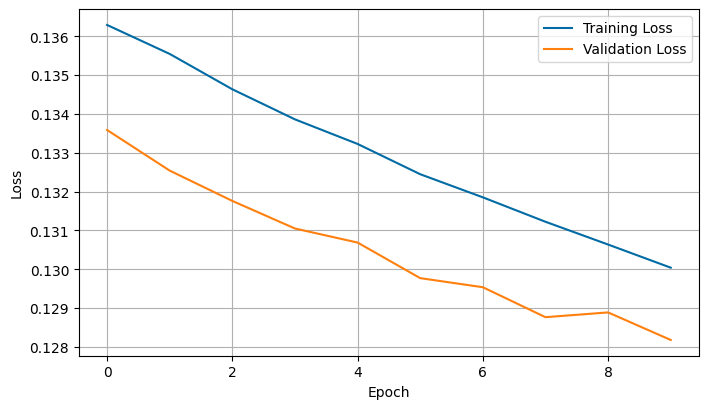

In [28]:
fig, ax = plot_history(history)

Picking Sample
Autencoding
Plotting transforms


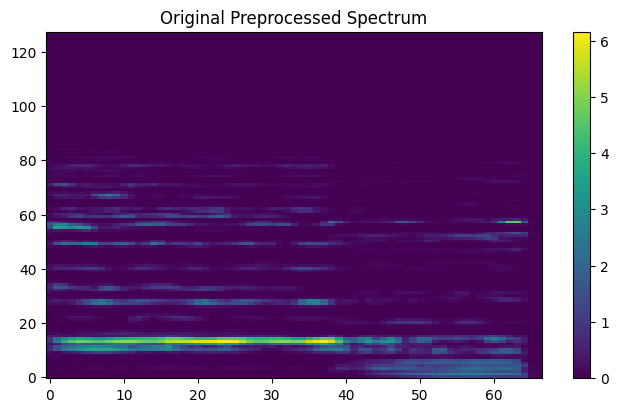

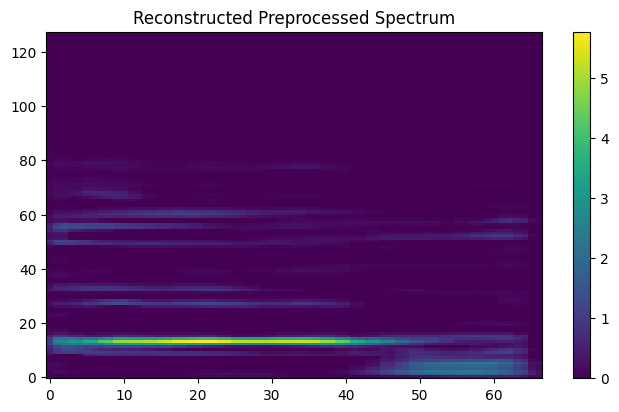

Postprocessing
Plotting transforms


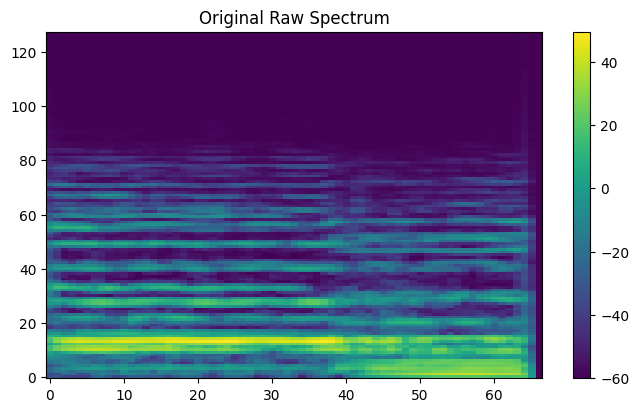

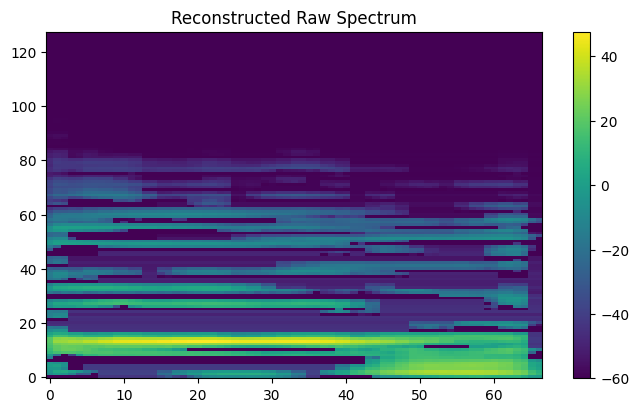

Reconstructing Audio


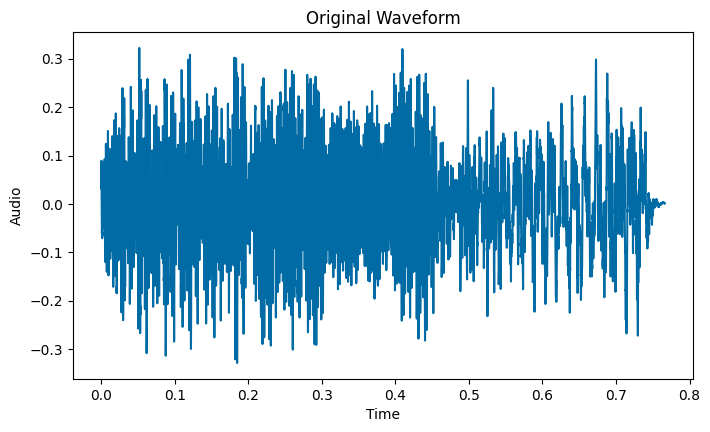

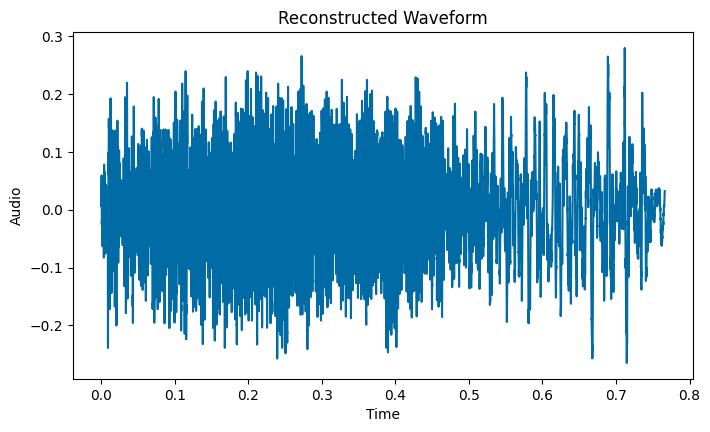

Original Audio


Reconstructed Audio


In [30]:
test_autoencoder(autoencoder)

### Variational Autencoder

In [59]:
class VariationalAutoencoder(krs.models.Model):
    # Based on: https://keras.io/examples/generative/vae/

    def __init__(
        self,
        feature_shape,
        compression,
        kernel_size, 
        conv_depth,
        input_chans_multiplier = 1,
        skip_connection=True, 
        activation="relu", 
        pooling_type="average",
        kl_reg = 1e-3,
    ):
        super().__init__()

        # Save parameters to class
        self.feature_shape = feature_shape
        self.compression = compression
        self.input_time, self.input_mels, self.input_chans = feature_shape
        self.kernel_size = kernel_size
        self.conv_depth = conv_depth
        self.input_chans_multiplier = input_chans_multiplier
        self.skip_connection = skip_connection
        self.activation = activation
        self.pooling_type = pooling_type
        self.kl_reg = kl_reg

        # Determine nr of layers to be used (and check config validity)
        self.k = np.log2(self.input_chans_multiplier)
        assert np.round(self.k) == self.k, "input_chans_multiplier should be a power of 2"
        self.l = np.log2(self.compression)
        assert np.round(self.l) == self.l, "compression should be a power of 2"
        assert self.input_mels / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input mels dimension"
        assert self.input_time / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input time dimension"
        self.n_layers = int(np.round(self.k + self.l))

        # Determine nr of channels & padding for the encoder layers
        layer_filters = [self.input_chans] + [self.input_chans * self.input_chans_multiplier * 2**(n + 1) for n in range(self.n_layers)]
        layer_padding, time = [None] * self.n_layers, self.input_time
        for n in range(self.n_layers):
            layer_padding[n] = time % 2 == 1
            time = (time + layer_padding[n]) // 2

        # Build encoders
        self.mu_encoder = Conv2DEncoder(
            layer_filters[1:],
            layer_padding,
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
            pooling_type=self.pooling_type,
        )

        self.sigma2_encoder = Conv2DEncoder(
            layer_filters[1:],
            layer_padding,
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
            pooling_type=self.pooling_type
        )

        # Build decoder
        self.decoder = Conv2DDecoder(
            layer_filters[::-1][1:],
            layer_padding[::-1],
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
        )

        # Keep track of losses
        self.loss_tracker = krs.metrics.Mean(name="loss") # total loss
        self.r_loss_tracker = krs.metrics.Mean(name="r_loss") # reconstruction loss
        self.kl_loss_tracker = krs.metrics.Mean(name="kl_loss") # kullback leibler loss
    
    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.r_loss_tracker,
            self.kl_loss_tracker,
        ]

    def encode(self, x):
        mu = self.mu_encoder(x)
        logsigma2 = self.sigma2_encoder(x)
        return mu, logsigma2
    
    def reparametrize(self, mu, logsigma2):
        z = tf.random.normal(shape=logsigma2.shape[1:])
        h = mu + tf.exp(logsigma2) * z
        return h
    
    def decode(self, h):
        x_hat = self.decoder(h)
        return x_hat

    def call(self, x):
        mu, logsigma2 = self.encode(x)
        h = self.reparametrize(mu, logsigma2)
        x_hat = self.decode(h)
        return x_hat
    
    def compute_r_loss(self, x, x_hat):
        r_loss = tf.reduce_mean(tf.abs(x - x_hat)) # MeanAbsoluteError
        self.r_loss_tracker.update_state(r_loss)
        return r_loss

    def compute_kl_loss(self, mu, logsigma2):
        # See: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
        kl_loss = tf.reduce_mean(1/2 * (tf.exp(logsigma2) + mu**2 - logsigma2 - 1))
        self.kl_loss_tracker.update_state(kl_loss)
        return kl_loss

    def compute_loss(self, x, x_hat, mu, logsigma2):
        r_loss = self.compute_r_loss(x, x_hat)
        kl_loss = self.compute_kl_loss(x, x_hat)
        loss = r_loss + self.kl_reg * kl_loss
        self.loss_tracker.update_state(loss)
        return loss
    
    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward propagation
        with tf.GradientTape() as tape:
            # Autoencode
            mu, logsigma2 = self.encode(x)
            h = self.reparametrize(mu, logsigma2)
            x_hat = self.decode(h)

            # Compute loss factors
            loss = self.compute_loss(x, x_hat, mu, logsigma2)
        
        # Backpropagation
        trainable_weights = self.trainable_weights
        gradients = tape.gradient(loss, self.trainable_weights)

        # Optimization step
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))

        # Return loss
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        # Unpack data
        x, y = data

        # Autoencode
        mu, logsigma2 = self.encode(x)
        h = self.reparametrize(mu, logsigma2)
        x_hat = self.decode(h)

        # Commute loss factors
        loss = self.compute_loss(x, x_hat, mu, logsigma2)

        # Return losses
        return {m.name: m.result() for m in self.metrics}

In [60]:
compression = 8
kernel_size = 3
conv_depth = 1
input_chans_multiplier = 1
skip_connection = False
pooling_type = "average"
kl_reg = 1e-3

autoencoder = VariationalAutoencoder(
    input_shape,
    compression,
    kernel_size,
    conv_depth,
    input_chans_multiplier=input_chans_multiplier,
    skip_connection=skip_connection,
    pooling_type=pooling_type,
    kl_reg=kl_reg
)

In [61]:
autoencoder.compile(optimizer="adam", loss=krs.losses.MeanAbsoluteError())

In [62]:
history = autoencoder.fit(X_train, X_train, epochs=25, shuffle=True, validation_data=(X_test, X_test), verbose=1)

Epoch 1/25


KeyboardInterrupt: 

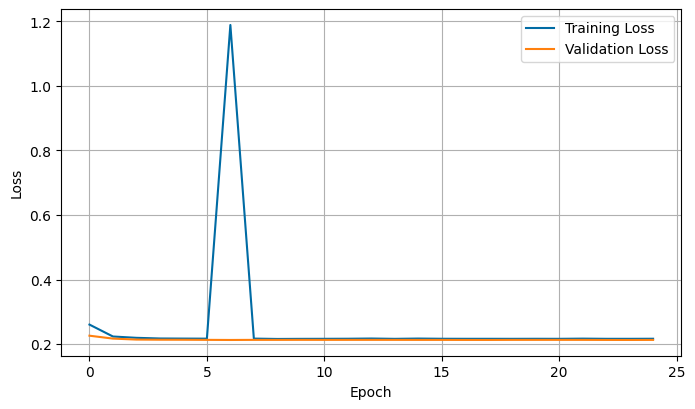

In [48]:
fig, ax = plot_history(history)

Picking Sample
Autencoding
Plotting transforms


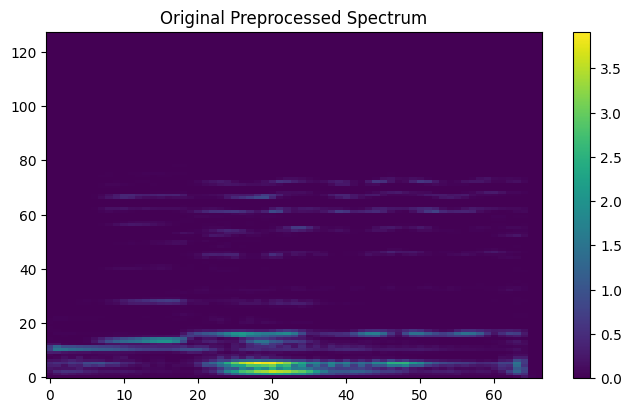

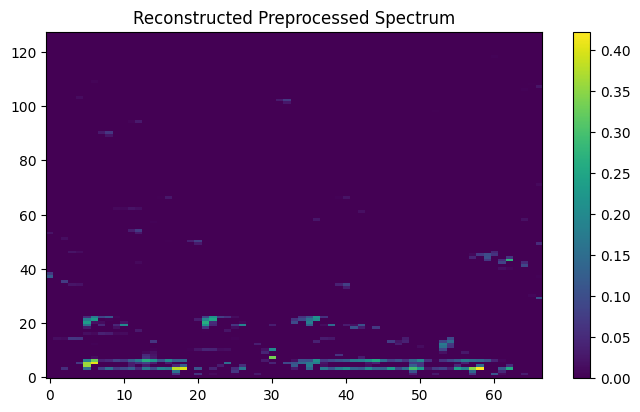

Postprocessing
Plotting transforms


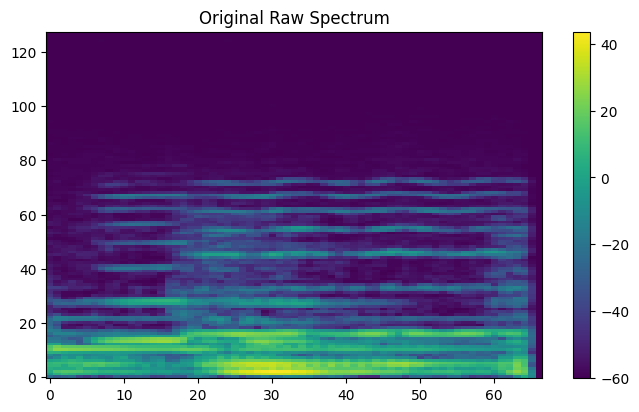

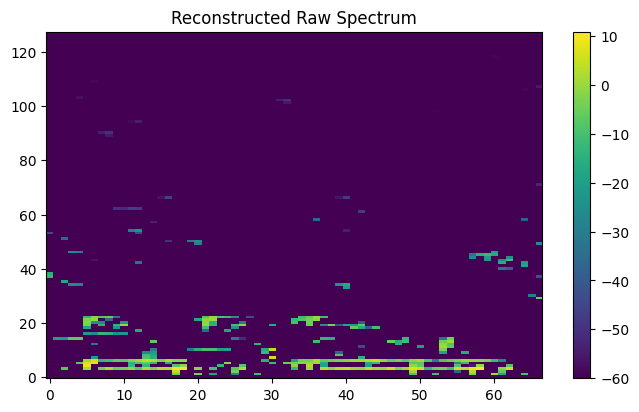

Reconstructing Audio


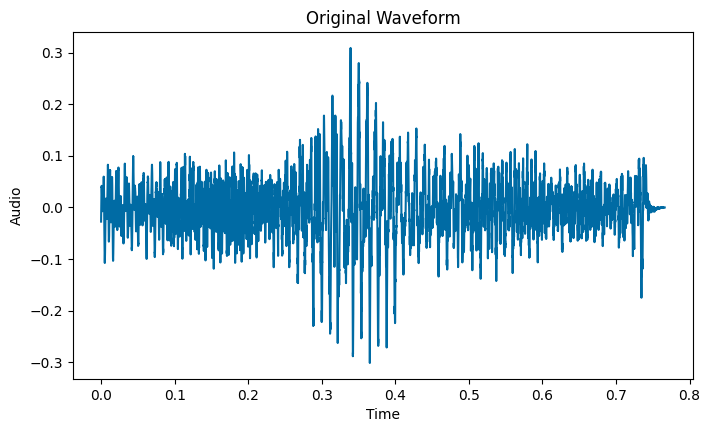

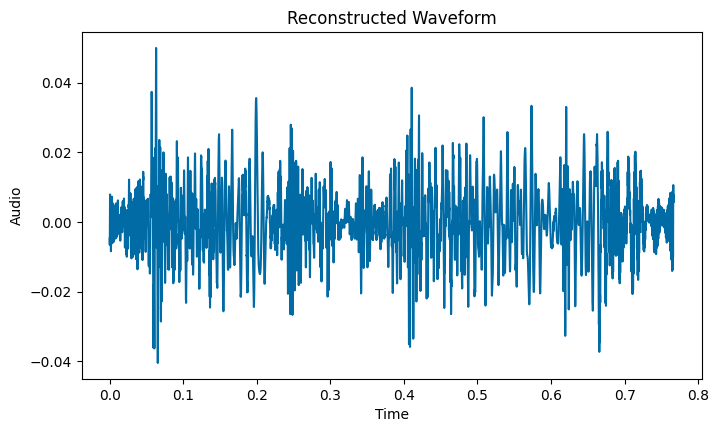

Original Audio


Reconstructed Audio


In [50]:
test_autoencoder(autoencoder)

### GAN Autoencoder

In [85]:
@krs.saving.register_keras_serializable()
class GANDiscriminator(krs.models.Model):
    def __init__(
        self,
        feature_shape,
        mlp_layers,
        conv_compression,
        conv_kernel_size,
        conv_pooling_type="max",
    ):
        super().__init__()
        
        # Store parameters
        self.feature_shape = feature_shape
        self.feature_size = np.prod(feature_shape)
        self.input_time, self.input_mels, self.input_chans = feature_shape
        self.conv_compression = conv_compression
        self.conv_kernel_size = conv_kernel_size
        self.conv_depth = 1
        self.conv_input_chans_multiplier = 1
        self.conv_skip_connection = False
        self.conv_activation = "relu"
        self.conv_pooling_type = conv_pooling_type
        self.mlp_layers = mlp_layers
        self.mlp_activation = "relu"
        self.output_activation = "sigmoid"

        # CNN feature extractor
        self.conv_layers = np.log2(conv_compression)
        assert self.conv_layers == np.round(self.conv_layers), "compression should be a power of 2"
        self.conv_layers = int(self.conv_layers)
        conv_layer_filters = [self.input_chans * self.conv_input_chans_multiplier * 2**(n+1) for n in range(self.conv_layers)]
        conv_layer_padding = [False] * self.conv_layers
        self.cnn = Conv2DEncoder(
            conv_layer_filters,
            conv_layer_padding,
            self.conv_kernel_size,
            self.conv_depth,
            skip_connection=self.conv_skip_connection,
            activation=self.conv_activation,
            pooling_type=self.conv_pooling_type
        )

        # MLP classifier
        mlp_input_size = self.feature_size / self.conv_compression
        mlp_output_size = 1
        mlp_hidden_dims = np.round(np.logspace(np.log2(mlp_input_size), np.log2(mlp_output_size), self.mlp_layers + 1, base=2)[1:-1]).astype(int)
        print(f"{mlp_hidden_dims = }")
        self.mlp = MLP(
            mlp_hidden_dims,
            mlp_output_size,
            hidden_activation=self.mlp_activation,
            output_activation=self.output_activation,
        )

        # Keep track of losses
        self.d_loss_tracker = krs.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.d_loss_tracker]

    def compute_loss(self, p_real, p_fake):
        # RaGAN loss
        # The discriminator wants p_real to be close to 1 and p_fake to be close to 0
        real_loss = tf.reduce_mean(((p_real - 1) - tf.reduce_mean(p_fake))**2)
        fake_loss = tf.reduce_mean(((p_fake + 1) - tf.reduce_mean(p_real))**2)
        d_loss = (real_loss + fake_loss) / 2
        self.d_loss_tracker.update_state(d_loss)
        return d_loss
    
    def call(self, x):
        # Extract features
        h = self.cnn(x)
        # Classify
        p = self.mlp(h)
        
        return p

    def train_step(self, data, generator):
        # Unpack data
        x, y = data

        # Generate real & fake sample
        x_real, x_fake = generator(x)

        # Forward propagation
        with tf.GradientTape() as tape:
            # Discriminate
            p_real = self.call(x_real)
            p_fake = self.call(x_fake)

            # Compute loss
            loss = self.compute_loss(p_real, p_fake)

        # Backward propagation
        trainable_weights = self.trainable_weights
        gradients = tape.gradient(loss, trainable_weights)

        # Optimizer step
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))

        # Return loss
        return {m.name: m.result() for m in self.metrics}

In [101]:
class GANGenerator(krs.models.Model):
    def __init__(
        self,
        feature_shape,
        compression,
        kernel_size, 
        conv_depth,
        input_chans_multiplier = 1,
        skip_connection=True, 
        activation="relu", 
        pooling_type="average",
        gan_reg = 1e-3,
        c_reg = 1e-3,
        s_reg = 1e-3,
    ):
        super().__init__()

        # Save parameters
        self.feature_shape = feature_shape
        self.input_time, self.input_mels, self.input_chans = feature_shape
        self.compression = compression
        self.kernel_size = kernel_size
        self.conv_depth = conv_depth
        self.input_chans_multiplier = input_chans_multiplier
        self.skip_connection = skip_connection
        self.activation = activation
        self.pooling_type = pooling_type
        self.gan_reg = gan_reg
        self.c_reg = c_reg
        self.s_reg = s_reg

        # Determine nr of layers to be used (and check config validity)
        k = np.log2(self.input_chans_multiplier)
        assert np.round(k) == k, "input_chans_multiplier should be a power of 2"
        l = np.log2(self.compression)
        assert np.round(l) == l, "compression should be a power of 2"
        assert self.input_mels / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input mels dimension"
        assert self.input_time / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input time dimension"
        self.n_layers = int(np.round(k + l))

        # Determine nr of channels & padding for the encoder layers
        layer_filters = [self.input_chans] + [self.input_chans * self.input_chans_multiplier * 2**(n + 1) for n in range(self.n_layers)]
        layer_padding, time = [None] * self.n_layers, self.input_time
        for n in range(self.n_layers):
            layer_padding[n] = time % 2 == 1
            time = (time + layer_padding[n]) // 2
        
        # Build encoders
        self.style_encoder = Conv2DEncoder(
            layer_filters[1:],
            layer_padding,
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
            pooling_type=self.pooling_type,
        )

        self.content_encoder = Conv2DEncoder(
            layer_filters[1:],
            layer_padding,
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
            pooling_type=self.pooling_type
        )

        # Build decoder
        self.decoder = Conv2DDecoder(
            layer_filters[::-1][1:],
            layer_padding[::-1],
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
        )

        # Keep track of losses
        self.g_loss_tracker = krs.metrics.Mean(name="loss") # Total loss
        self.r_loss_tracker = krs.metrics.Mean(name="r_loss") # Reconstruction loss
        self.gan_loss_tracker = krs.metrics.Mean(name="gan_loss") # Adverserial loss
        self.c_loss_tracker = krs.metrics.Mean(name="c_loss") # Content loss
        self.s_loss_tracker = krs.metrics.Mean(name="s_loss") # Style loss
    
    @property
    def metrics(self):
        return [self.g_loss_tracker, self.r_loss_tracker, self.gan_loss_tracker, self.c_loss_tracker, self.s_loss_tracker]
    
    def encode(self, x):
        content = self.content_encoder(x)
        style = self.style_encoder(x)
        return content, style

    def sample_style(self, style):
        style_fake = tf.random.normal(shape = style.shape[1:])
        return style_fake

    def decode(self, content, style):
        h = content + style
        x_hat = self.decoder(h)
        return x_hat

    def call(self, x):
        # Encode sample to content & style
        content, style = self.encode(x)

        # Generate fake style
        style_fake = self.sample_style(style)

        # Decode real and fake sample
        x_real = self.decode(content, style)
        x_fake = self.decode(content, style_fake)

        return x_real, x_fake

    def compute_r_loss(self, x, x_real):
        r_loss = tf.reduce_mean(tf.abs(x - x_real)) # MeanAbsoluteError
        self.r_loss_tracker.update_state(r_loss)
        return r_loss
    
    def compute_gan_loss(self, p_real, p_fake):
        # RaGAN loss
        # The generator wants p_real to be close to 0 and p_fake to be close to 1
        real_loss = tf.reduce_mean(((p_real + 1) - tf.reduce_mean(p_fake))**2)
        fake_loss = tf.reduce_mean(((p_fake - 1) - tf.reduce_mean(p_real))**2)
        gan_loss = (real_loss + fake_loss) / 2
        self.gan_loss_tracker.update_state(gan_loss)
        return gan_loss

    def compute_c_loss(self, content, content_hat):
        c_loss = tf.reduce_mean(tf.abs(content - content_hat))
        self.c_loss_tracker.update_state(c_loss)
        return c_loss
    
    def compute_s_loss(self, style_fake, style_fake_hat):
        s_loss = tf.reduce_mean(tf.abs(style_fake - style_fake_hat))
        self.s_loss_tracker.update_state(s_loss)
        return s_loss
    
    def compute_loss(self, x, content, style, style_fake, x_real, x_fake, p_real, p_fake, content_hat, style_fake_hat):
        # Compute loss contributions
        r_loss = self.compute_r_loss(x, x_real)
        gan_loss = self.compute_gan_loss(p_real, p_fake)
        c_loss = self.compute_c_loss(content, content_hat)
        s_loss = self.compute_s_loss(style_fake, style_fake_hat)

        g_loss = r_loss + self.gan_reg * gan_loss + self.c_reg * c_loss + self.s_reg * s_loss
        self.g_loss_tracker.update_state(g_loss)
        return g_loss
    
    def train_step(self, data, discriminator):
        # Unpack data
        x, y = data

        # Forward propagation
        with tf.GradientTape() as tape:
            # Encode real
            content, style = self.encode(x)

            # Create fake style
            style_fake = self.sample_style(style)

            # Decode real and fake
            x_real = self.decode(content, style)
            x_fake = self.decode(content, style_fake)

            # Discriminate
            p_real = discriminator(x_real)
            p_fake = discriminator(x_fake)
        
            # Encode fake
            content_hat, style_fake_hat = self.encode(x_fake)

            # Compute loss
            loss = self.compute_loss(x, content, style, style_fake, x_real, x_fake, p_real, p_fake, content_hat, style_fake_hat)
        
        # Backpropagation
        trainable_weights = self.trainable_weights
        gradients = tape.gradient(loss, trainable_weights)

        # Optimization step
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))

        # Return loss
        return {m.name: m.result() for m in self.metrics}

In [102]:
class GAN(krs.models.Model):
    def __init__(self, generator, discriminator):
        super().__init__()

        self.generator = generator
        self.discriminator = discriminator
    
    @property
    def metrics(self):
        return self.generator.metrics + self.discriminator.metrics

    def compile(self, g_optimizer, d_optimizer):
        super().compile()
        self.generator.compile(g_optimizer)
        self.discriminator.compile(d_optimizer)
    
    def train_step(self, data):
        # Unpack data
        x, y = data

        # Train discriminator
        self.discriminator.train_step(data, self.generator)

        # Train generator
        self.generator.train_step(data, self.discriminator)

        # Return metrics
        return {m.name: m.result() for m in self.metrics}

In [103]:
compression = 8
kernel_size = 3
conv_depth = 1
input_chans_multiplier = 1
skip_connection = False
pooling_type = "average"
gan_reg = 1.
c_reg = 1.
s_reg = 1.
mlp_layers = 2

generator = GANGenerator(
    input_shape,
    compression,
    kernel_size,
    conv_depth,
    input_chans_multiplier=input_chans_multiplier,
    skip_connection=skip_connection,
    pooling_type=pooling_type,
    gan_reg=gan_reg,
    c_reg = c_reg,
    s_reg=s_reg,
)

discriminator = GANDiscriminator(
    input_shape,
    mlp_layers,
    compression,
    kernel_size,
)

mlp_hidden_dims = array([33])


In [104]:
gan = GAN(generator, discriminator)

In [105]:
gan.compile("adam", "adam")

In [106]:
history = gan.fit(X_train, X_train, epochs=25, shuffle=True, verbose=1)

Epoch 1/25
29/29 [==============================] - 9s 140ms/step - loss: 3.4113 - r_loss: 0.2124 - gan_loss: 2.3951 - c_loss: 0.0040 - s_loss: 0.7999 - d_loss: 0.5360
Epoch 2/25
29/29 [==============================] - 4s 142ms/step - loss: 4.9334 - r_loss: 0.2155 - gan_loss: 3.9216 - c_loss: 0.0013 - s_loss: 0.7950 - d_loss: 0.0120
Epoch 3/25
29/29 [==============================] - 4s 141ms/step - loss: 4.8140 - r_loss: 0.2159 - gan_loss: 3.7928 - c_loss: 0.0015 - s_loss: 0.8038 - d_loss: 0.0324
Epoch 4/25
29/29 [==============================] - 4s 141ms/step - loss: 2.9775 - r_loss: 0.2716 - gan_loss: 1.6819 - c_loss: 0.0015 - s_loss: 1.0225 - d_loss: 0.7128
Epoch 5/25
29/29 [==============================] - 4s 145ms/step - loss: 4.1508 - r_loss: 0.2637 - gan_loss: 3.0819 - c_loss: 0.0010 - s_loss: 0.8042 - d_loss: 0.2085
Epoch 6/25
29/29 [==============================] - 5s 161ms/step - loss: 2.2771 - r_loss: 0.2158 - gan_loss: 1.2585 - c_loss: 5.0700e-04 - s_loss: 0.8023 - d_l